In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import torch

from escnn import gspaces
from escnn import nn

In [65]:
from e3nn import o3

import matplotlib.pyplot as plt


from neurorient import get_model_size, display_images
from neurorient.predictors import BaseSO3Predictor, I2S
from neurorient.external.image2sphere import so3_healpix_grid, flat_wigner, wigner_D, plot_so3_distribution

In [150]:
model = I2S(
    encoder='steerablecnn',
    encoder_input_shape=(1, 128, 128),
    eval_wigners_file='/pscratch/sd/z/zhantao/neurorient_repo/data/eval_wigners_lmax6_rec5.pt')


building block 2
building block 3
building block 4
building block 5
building block 6
building block 7
building block 8
torch.Size([1, 192, 62, 62])
torch.Size([1, 384, 32, 32])
torch.Size([1, 768, 17, 17])
torch.Size([1, 1536, 10, 10])


In [143]:
model.encoder

SteerableCNN(
  (block1): SequentialModule(
    (0): MaskModule()
    (1): R2Conv([C8_on_R2[(None, 8)]: {irrep_0 (x1)}(1)], [C8_on_R2[(None, 8)]: {regular (x12)}(96)], kernel_size=7, stride=1, padding=1, bias=False)
    (2): InnerBatchNorm([C8_on_R2[(None, 8)]: {regular (x12)}(96)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True, type=[C8_on_R2[(None, 8)]: {regular (x12)}(96)])
  )
  (block2): SequentialModule(
    (0): R2Conv([C8_on_R2[(None, 8)]: {regular (x12)}(96)], [C8_on_R2[(None, 8)]: {regular (x24)}(192)], kernel_size=5, stride=1, padding=2, bias=False)
    (1): InnerBatchNorm([C8_on_R2[(None, 8)]: {regular (x24)}(192)], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True, type=[C8_on_R2[(None, 8)]: {regular (x24)}(192)])
  )
  (pool1): SequentialModule(
    (0): PointwiseAvgPoolAntialiased2D()
  )
  (block3): SequentialModule(
    (0): R2Conv([C8_on_R2[(None, 8)]: {regular (x24)}(192)], [C8_on_R

In [147]:
get_model_size(model.encoder);

model size: 91.605MB


In [ ]:
get_model_size(model.encoder);

model size: 91.605MB


In [148]:
model.encoder.output_shape

torch.Size([1536, 7, 7])

In [25]:
# define equally spaced grid over so3
# it can be slow to generate grid for large rec_levels
output_xyx = so3_healpix_grid(rec_level=model.train_grid_rec_level) # 37K points
output_wigners = flat_wigner(model.lmax, *output_xyx).transpose(0, 1)
output_rotmats = o3.angles_to_matrix(*output_xyx)

In [105]:
# create random input for demonstration purposes
img = torch.randn((1, 3, 128, 128))
spi_data = torch.load('/pscratch/sd/z/zhantao/neurorient_repo/data/1bxr_train.pt')
img = spi_data['images'][0].unsqueeze(0).unsqueeze(0)
# img = img.repeat(1,3,1,1)

gt_rot = torch.eye(3).unsqueeze(0)


In [53]:
import torchvision

In [118]:
images = []
for angle in [30, 45, 90, 135, 180]:
    img_rotated = torchvision.transforms.functional.rotate(img, angle)
    images.append(img_rotated)

images = torch.vstack(images)

In [130]:
img_embed = model.encoder(images).detach().cpu()

In [131]:
img_embed.shape

torch.Size([5, 1536, 7, 7])

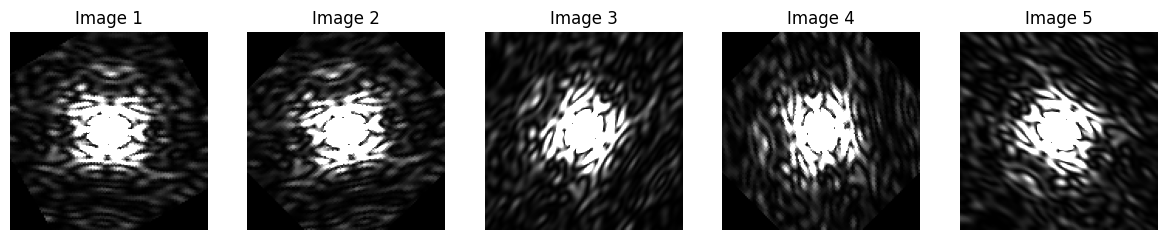

In [132]:
display_images(images[:,0], columns=8, vmax=3)

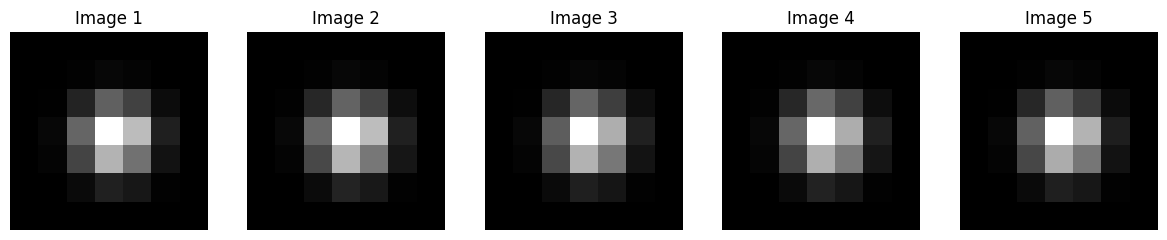

In [133]:
display_images(img_embed[:,:8].mean(dim=1), columns=8)

In [134]:
model.encoder.feat_after_pool1.shape

torch.Size([5, 192, 62, 62])

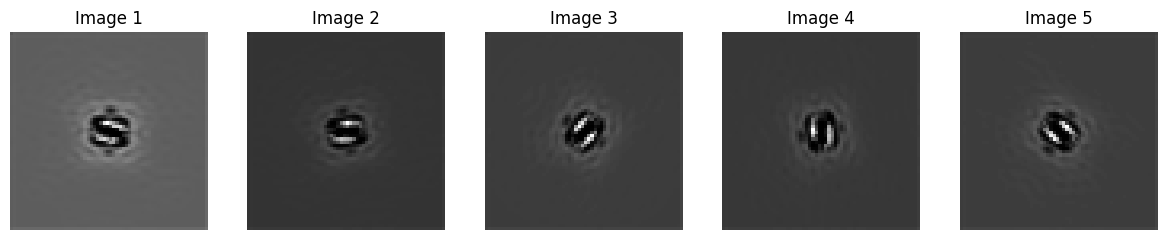

In [135]:
display_images(model.encoder.feat_after_pool1[:,:8].mean(dim=1), columns=8)

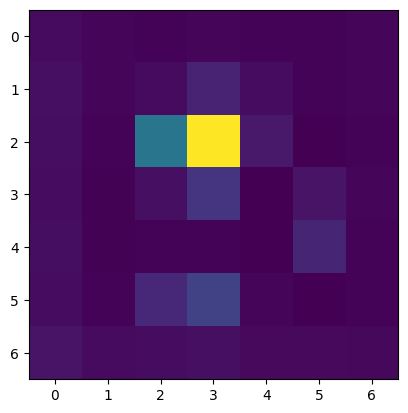

In [117]:
plt.imshow(img_embed[0,0])

In [32]:
probs = model.compute_probabilities(img, output_wigners, use_o_for_eval=True)

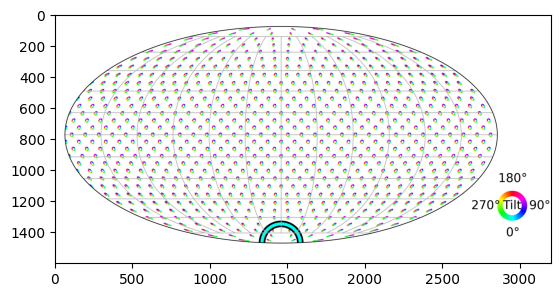

In [34]:
import matplotlib.pyplot as plt
fig = plot_so3_distribution(probs[0], output_rotmats, gt_rotation=gt_rot);
plt.imshow(fig)

In [74]:
from neurorient import average_quaternions, weighted_average_quaternions

quats = torch.rand(10, 4)
weights = torch.rand(10)
weights = weights / weights.sum()

In [76]:
print(average_quaternions(quats))
print(weighted_average_quaternions(quats, weights))

tensor([-0.5318, -0.4633, -0.4229, -0.5689], dtype=torch.float64)
tensor([-0.5303, -0.4717, -0.4903, -0.5058], dtype=torch.float64)


In [77]:
from sksurgerycore.algorithms.averagequaternions import average_quaternions, weighted_average_quaternions

In [78]:
print(average_quaternions(quats.numpy()))
print(weighted_average_quaternions(quats.numpy(), weights.numpy()))

[-0.53180299 -0.46328856 -0.42291813 -0.56893721]
[-0.53032443 -0.47173301 -0.49030564 -0.5057908 ]


In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
model = C8SteerableCNN()

In [32]:
model(torch.rand(5, 1, 29, 29))

torch.Size([5, 64, 1, 1])


tensor([[-0.9317,  0.5064,  0.7547,  0.5753,  0.0010,  0.5284, -0.0661, -0.4555,
          0.4454,  0.1481],
        [ 0.0920, -0.2049, -0.1473, -0.6972,  0.2486, -0.3775, -0.5651,  0.2824,
          0.2450, -0.3624],
        [-0.6476,  0.2706, -0.7281,  0.4857, -0.2309,  0.0661,  0.5877,  0.1130,
          0.3332,  0.1303],
        [ 0.2717,  0.2406, -0.3162,  0.5159,  0.1837,  0.1114, -0.3194,  0.1093,
          0.4721, -0.4172],
        [ 0.7263, -0.6070, -0.1277,  0.3976,  0.4570,  0.3050,  0.0807,  0.4410,
         -0.8528, -0.0562]], grad_fn=<AddmmBackward0>)